In [126]:
#reference https://www.kaggle.com/c/trackml-particle-identification/discussion/57643

import os
from trackml.score  import score_event
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares


particle id:4503805785800704
2.080500358740693
[[ -16.7566   35.42    597.5   ]
 [ -16.7823   35.4723  598.    ]
 [ -16.8861   35.7364  602.5   ]
 [ -19.5302   41.3919  698.    ]
 [ -19.6603   41.6499  702.5   ]
 [ -22.8187   48.4808  818.    ]
 [ -22.9757   48.7395  822.5   ]
 [ -26.6282   56.8026  958.    ]
 [ -26.747    57.0602  962.5   ]
 [ -30.436    65.1217 1098.    ]
 [ -30.5722   65.3804 1102.5   ]
 [ -35.9358   77.284  1302.5   ]
 [ -41.2285   89.2778 1502.5   ]]
[39.18367062 39.24193752 39.52506367 45.76809039 46.05693831 53.58246951
 53.88340794 62.73433192 63.01800087 71.88314063 72.1751766  85.23026679
 98.33775869]


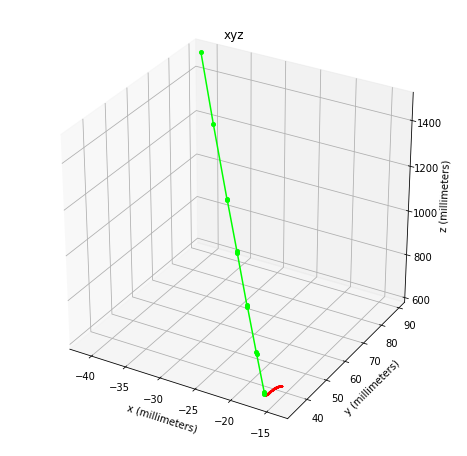

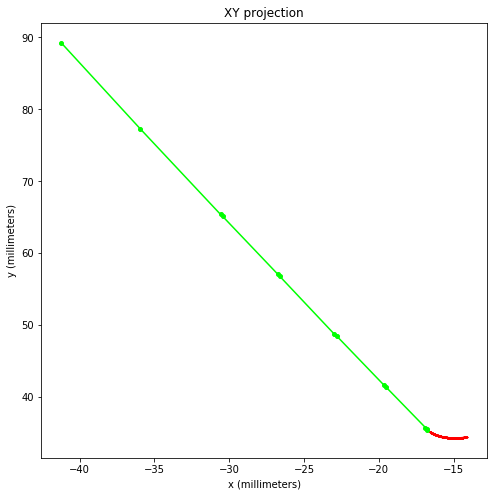

In [138]:
# estimate helix paramater space
def helix_estimate_param_from_track(xyz):
    
    def residuals_xy(param, x, y):
        x0, y0 = param
        r = np.sqrt((x-x0)**2 + (y-y0)**2)
        d = r - r.mean()
        return d
    
    def residuals_z(param, r, z):
        m2,m1,m0 = param
        zz = m2*r**2 + m1*r + m0
        d = z - zz
        return d
    
    x = xyz[:3,0]
    y = xyz[:3,1]
    z = xyz[:3,2]
    
    param0 = (x.mean(), y.mean())
    res_lsq = least_squares(residuals_xy, param0, loss='soft_l1', f_scale=1.0, args=(x,y))
    x0,y0 = res_lsq.x
    r0 = np.sqrt((x-x0)**2 + (y-y0)**2).mean()
    r = np.sqrt(x**2 + y**2)
    
    if 1:
        param0 = (0,0,0)
        res_lsq = least_squares(residuals_z, param0, args=(r, z))
        m2, m1, m0 = res_lsq.x
        
    if 0:
        # polynomial fit of the degree 2, x**2 - quadradic 
        m2,m1,m0 = np.polyfit(r,z,2)
        
    param = (x0,y0,r0,m1,m2,m0)
    return param

# convert x,y,z to curve space
def helix_search_theta(xyz, param, S=2.5):
    
    x0, y0, r0, m2, m1, m0 = param
    theta0 = np.arctan2(y0, x0)
    #sort by z
    xyz = xyz[np.argsort(np.fabs(xyz[:,2]))]
    xx = xyz[:,0] - x0
    yy = xyz[:,1] - y0
    x = xx*np.cos(-theta0) - yy*np.sin(-theta0)
    y = xx*np.sin(-theta0) + yy*np.cos(-theta0)
    theta = np.arctan(y, -x)
    
    theta_min = 0
    theta_max = theta[-1]
    theta_num = S*len(xyz)*50
    return np.linspace(theta_min, theta_max, theta_num)
    

def helix_generate_track_from_param(param, theta=np.linspace(0, 2*np.pi, 360)):
    x0, y0, r0, m1, m2, m0 = param
    theta0 = np.arctan2(y0, x0)
    xx = -r0*np.cos(theta)
    yy = r0*np.sin(theta)
    x = xx*np.cos(theta0) - yy*np.sin(theta0)+x0
    y = xx*np.sin(theta0) + yy*np.cos(theta0)+y0
    
    r = np.sqrt(x**2 + y**2)
    z = m2*r**2 + m1*r + m0
    
    xyz = np.column_stack([x,y,z])
    return xyz
        
# calculate r/2r0
def calculate_r0_r_ratio(xyz, r0):
    xyz = xyz[np.argsort(np.fabs(xyz[:,2]))]
    x = xyz[:,0]
    y = xyz[:,1]
    r = np.sqrt(x**2 + y**2)
    ratio = 0.5*r/r0
    #print('r:' + str(r))
    return ratio

# the angle we use for helix unrolling in dbscan
def helix_unroll_angle(xyz, ratio):
    xyz = xyz[np.argsort(np.fabs(xyz[:,2]))]
    x = xyz[:,0]
    y = xyz[:,1]
    angle = np.arctan2(y,x) - np.arccos(ratio)
    return angle
    
def study_all_helix_param():
       ## load an event ---
    event_id = '1030'
    data_dir  = '../../../input/train_100_events'
    csv_dir = '../../../input/'
    
    particles = pd.read_csv(os.path.join(data_dir, 'event00000%s-particles.csv'%event_id))
    hits      = pd.read_csv(os.path.join(data_dir, 'event00000%s-hits.csv' %event_id))
    truth     = pd.read_csv(os.path.join(data_dir, 'event00000%s-truth.csv'%event_id))
    
    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')
    
    #--------------------------------------------------------
    df = truth.copy()
    p = df[['particle_id']].values.astype(np.int64)
    particle_ids = np.unique(p)
    r0_ratio_list = []
    r0_list = []
    id_list = []
    particle_ids = particle_ids[particle_ids!=0]
    for index, id in enumerate(particle_ids):
        t = df.loc[(df.particle_id==id)].as_matrix(columns=['x','y','z'])
        if len(t) < 4:
            continue 
        t = t[np.argsort(np.fabs(t[:,2]))]
        x0, y0, r0, m1, m2, m0  = helix_estimate_param_from_track(t)
        ratio = calculate_r0_r_ratio(t, r0)
        angle = helix_unroll_angle(t, ratio)
        r0_ratio_list.extend(ratio)
        #print('r0:' + str(r0))
        r0_list.append(r0)
        if r0 > 1 and r0 < 50:
            id_list.append(id)
            print(id)
        #print('r/2r0:' + str(ratio))
        
    
    return r0_list, r0_ratio_list, id_list


def study_helix_param():
    # Change this from 0 - 83xx :number of particles
    track_id = 1
     ## load an event ---
    event_id = '1030'

    data_dir  = '../../../input/train_100_events'
    csv_dir = '../../../input/'
    
    particles = pd.read_csv(os.path.join(data_dir, 'event00000%s-particles.csv'%event_id))
    hits      = pd.read_csv(os.path.join(data_dir, 'event00000%s-hits.csv' %event_id))
    truth     = pd.read_csv(os.path.join(data_dir, 'event00000%s-truth.csv'%event_id))
    
    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')
    
    #--------------------------------------------------------
    df = truth.copy()
    p = df[['particle_id']].values.astype(np.int64)
    particle_ids = np.unique(p)
    particle_ids = particle_ids[particle_ids!=0]

    print('particle id:'+ str(particle_ids[track_id]))
    t = df.loc[(df.particle_id==4513563951497216)].as_matrix(columns=['x','y','z'])
    t = t[np.argsort(np.fabs(t[:,2]))]

    param = helix_estimate_param_from_track(t)
    theta = helix_search_theta(t, param, S=1)
    x0, y0, r0, m1, m2, m0 = param
    
    ## Visualization only 
    helix = helix_generate_track_from_param(param, theta=theta)
    
    print(r0)
    print(t)
    x = t[:,0]
    y = t[:,1]
    r = np.sqrt(x**2 + y**2)
    print(r)
    
    fig1 = plt.figure(figsize=(8, 8))
    ax1 = fig1.add_subplot(111, projection='3d')

    ax1.plot(helix[:,0], helix[:,1], helix[:,2], '.-', color=[1,0,0], markersize=1)
    # ground truth
    ax1.plot(t[:,0], t[:,1], t[:,2], '.-', color=[0,1,0], markersize=8)
    
    
    ax1.set_title('xyz')
    ax1.set_xlabel('x (millimeters)')
    ax1.set_ylabel('y (millimeters)')
    ax1.set_zlabel('z (millimeters)')
    
    fig2 = plt.figure(figsize=(8, 8))
    ax2 = fig2.add_subplot(111)
    
    ax2.plot(helix[:,0], helix[:,1], '.-', color=[1,0,0], markersize=1)
    # ground truth
    ax2.plot(t[:,0], t[:,1], '.-', color=[0,1,0], markersize=8)
    
    ax2.set_title('XY projection')
    ax2.set_xlabel('x (millimeters)')
    ax2.set_ylabel('y (millimeters)')
    

if __name__ == '__main__':
    
    #r0_list, r0_ratio_list, id_list = study_all_helix_param()
    study_helix_param()
    


(8598,)
(1203,)
(3223,)
(3967,)
(2171,)
(50,)
[1384.27174353 1948.15107499 1860.75179359 ... 2087.66015361 2650.79545458
 1573.38088907]
[5013.11198985 5687.62499915 8425.64483207 7849.70736002 6126.22485849
 7903.36696183 7347.81755422 6226.66378104 7351.06230771 5391.70202855
 6139.04873526 8063.43675162 8080.34806398 6809.46668805 5447.72747574
 8429.45849632 5014.66099295 5408.14383123 7662.23755575 6889.35202679
 6876.33595698 6854.70872957 5849.85374655 7408.50321811 6403.86183799
 5317.71745778 7812.06954008 6626.69120273 9509.90595741 5586.94452959
 7253.32181574 8747.5120327  5646.13563959 5042.88208319 6186.09570217
 5626.28421747 8024.37825043 5224.31009562 8592.61305626 5193.77915762
 7520.33398051 5357.00641611 6173.50374179 5453.6277478  5127.25906845
 5017.78001114 6426.37676677 5451.02225559 8218.92322323 5456.1598493
 7715.94909933 9891.22224005 5942.89790777 6263.61784513 5884.25676107
 5684.9071482  5702.60166285 5030.8378242  5707.98512845 8604.05893771
 5533.106662

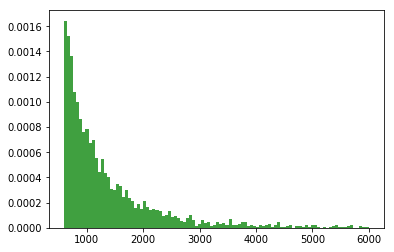

In [146]:
r0_list = np.asarray(r0_list)
print(r0_list.shape)
print(r0_list[ (r0_list>0) & (r0_list<=50) ].shape)
print(r0_list[ (r0_list>100) & (r0_list<=600) ].shape)

print(r0_list[r0_list>600].shape)
print(r0_list[r0_list>1000].shape)
print(r0_list[r0_list>10000].shape)


#n, bins, patches = plt.hist(r0_list[(r0_list>0) & (r0_list<=600)], 100, density=True, facecolor='g', alpha=0.75)
n, bins, patches = plt.hist(r0_list[(r0_list>600) & (r0_list<=6000)], 100, density=True, facecolor='g', alpha=0.75)
#n, bins, patches = plt.hist(r0_list[(r0_list>0) & (r0_list<=5000)], 100, density=True, facecolor='g', alpha=0.75)

print(r0_list[ (r0_list>1000) & (r0_list <= 5000) ])

print(r0_list[ (r0_list>5000) & (r0_list <= 10000) ])

print(r0_list[r0_list>10000])
